# Decision Tree

In [336]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn graphviz "ray[tune]"


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [337]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

## Model From Scratch

In [338]:
class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch(BaseEstimator, ClassifierMixin):
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._calculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _calculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparison (highest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, question, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=question[0], threshold=question[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

  def predict_proba(self, X):
    X = np.array(X)
    probs = []
    for sample in X:
        node = self.root
        while not isinstance(node, LeafNode):
            feature_value = sample[node.feature_index]
            if feature_value >= node.threshold:
                node = node.left
            else:
                node = node.right
        # compute class probability in this leaf node
        y_leaf = node.prediction_value
        # If you only stored a single class, just make it binary
        if y_leaf == 1:
            probs.append(1.0)
        else:
            probs.append(0.0)
    return np.array(probs)


## Preprocessing

In [339]:
# select dataset
dataset_path = "../Breast_Cancer_Preprocessed.csv"
df = pd.read_csv(dataset_path)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4024 non-null   int64  
 1   Tumor Size                4024 non-null   int64  
 2   Estrogen Status           4024 non-null   int64  
 3   Progesterone Status       4024 non-null   int64  
 4   Regional Node Examined    4024 non-null   int64  
 5   Reginol Node Positive     4024 non-null   int64  
 6   Survival Months           4024 non-null   int64  
 7   Status                    4024 non-null   int64  
 8   T Stage Ordinal           4024 non-null   float64
 9   N Stage Ordinal           4024 non-null   float64
 10  M Stage Ordinal           4024 non-null   float64
 11  Differentiate Ordinal     4024 non-null   float64
 12  Marital Status_Divorced   4024 non-null   int64  
 13  Marital Status_Married    4024 non-null   int64  
 14  Marital 

## Training

### Model Optimization Checklist

- Preprocessing
  - Encoding
  - Sampling
  - Standard Scaler
- Hyperparameters Tuning
  - Model Hyperparameters (min_sample_split, min_impurity, max_depth, criterion)
  - Grid Search
- Evaluation
  - Cross Validation

In [340]:
# Hyperparameters
criterion = "entropy"
max_depth = 10
# min_samples_leaf = 2
min_impurity = 1e-03
min_sample_split = 2

In [341]:
# X = df.drop(columns=["Status_encoded"])
X = df[
    [
        "Progesterone Status",
        "N Stage Ordinal",
        "Differentiate Ordinal",
        "Race_Other",
        "Marital Status_Divorced",
    ]
]
y = df["Status"]

In [342]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

alive_count = (y_test == 0).sum()
dead_count = (y_test == 1).sum()

print(f"number of alive patients: {alive_count}\nnumber of dead patients: {dead_count}")

number of alive patients: 685
number of dead patients: 120


In [343]:
# Oversampling
categorical_features = [
    X_train.columns.get_loc(c)
    for c in X_train.columns
    if "Marital Status" in c or "Race" in c
]


sm = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [344]:
# Grid Search
params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

# Define the Decision Tree model
model = DecisionTreeClassifier()

grid_dt = GridSearchCV(model, params, cv=5, scoring="accuracy")
grid_dt.fit(X_train, y_train)
print("Best parameters:\n", grid_dt.best_params_)
print("Best score:", grid_dt.best_score_)

Best parameters:
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 0.6735269290064954


In [345]:
# Grid Search
params = {
    "max_depth": tune.grid_search([3, 5, 10, None]),
    "min_sample_split": tune.grid_search([2, 5, 10]),
    "min_impurity": tune.grid_search([1e-7, 1e-5, 1e-3, 1e-2]),
    # "min_samples_leaf": tune.grid_search([1, 2, 4]),
    "criterion": tune.grid_search(["gini", "entropy"]),
}

scheduler = ASHAScheduler()


def train_decision_tree(config):
    # Create model with current hyperparameters
    model = DecisionTreeClassifierFromScratch(
        max_depth=config["max_depth"],
        min_sample_split=config["min_sample_split"],
        min_impurity=config["min_impurity"],
        criterion=config["criterion"],
    )

    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate accuracy
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)

    # Report metric back to Ray Tune
    session.report({"val_accuracy": acc})


analysis = tune.Tuner(
    tune.with_resources(train_decision_tree, resources={"cpu": 1}),
    tune_config=tune.TuneConfig(
        metric="val_accuracy",
        mode="max",
        scheduler=scheduler,
    ),
    param_space=params,
)

"""
🎉[INFO] Training is done!
Best config is: {'max_depth': 10, 'min_sample_split': 2, 'min_impurity': 0.001, 'criterion': 'entropy'}
Best result is: Result(
  metrics={'val_accuracy': 0.7776397515527951},
"""

# result = analysis.fit()

# print("🎉[INFO] Training is done!")
# print("Best config is:", result.get_best_result().config)
# print("Best result is:", result.get_best_result())

"\n🎉[INFO] Training is done!\nBest config is: {'max_depth': 10, 'min_sample_split': 2, 'min_impurity': 0.001, 'criterion': 'entropy'}\nBest result is: Result(\n  metrics={'val_accuracy': 0.7776397515527951},\n"

In [346]:
tree = DecisionTreeClassifierFromScratch(
    max_depth=max_depth,
    criterion=criterion,
    min_impurity=min_impurity,
    min_sample_split=min_sample_split,
)
# tree = DecisionTreeClassifier(max_depth=3, criterion="gini")
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
tree.draw_tree()

  (0) Is 1>=0.2581036730412849?: entropy:0.05
 ----- True branch :)
    (1) Is 3>=1.0?: entropy:0.04
   ----- True branch :)
      (2) Is 4>=1.0?: entropy:0.01
     ----- True branch :)
        The predicted value --> 0.0
     ----- False branch :)
        (3) Is 1>=2.0?: entropy:0.01
       ----- True branch :)
          (4) Is 2>=2.0?: entropy:0.09
         ----- True branch :)
            The predicted value --> 1.0
         ----- False branch :)
            (5) Is 0>=1.0?: entropy:0.05
           ----- True branch :)
              (6) Is 2>=1.0?: entropy:0.01
             ----- True branch :)
                The predicted value --> 0.0
             ----- False branch :)
                The predicted value --> 0.0
           ----- False branch :)
              (6) Is 2>=1.0?: entropy:0.25
             ----- True branch :)
                The predicted value --> 0.0
             ----- False branch :)
                The predicted value --> 0.0
       ----- False branch :)
          (

## Evaluation

In [347]:
# sklearn accuracy score
accuracy_score(y_true=y_test, y_pred=y_pred)

0.7776397515527951

In [348]:
def predict(model):
    model.fit(X_train, y_train)
    model.predict(X_test)
    print(classification_report(model.predict(X_test), y_test))

predict(tree)

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       632
         1.0       0.47      0.33      0.39       173

    accuracy                           0.78       805
   macro avg       0.65      0.61      0.63       805
weighted avg       0.75      0.78      0.76       805



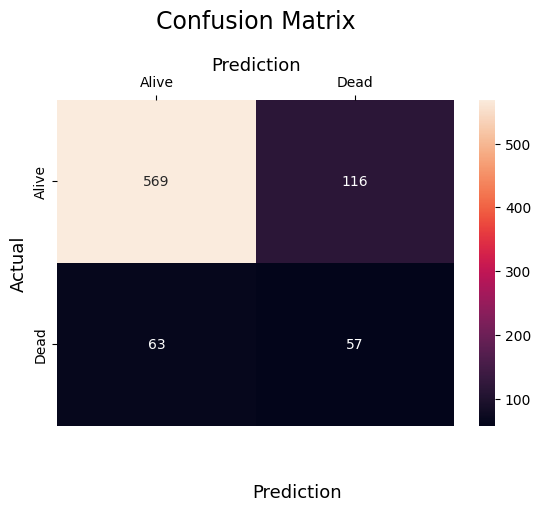

In [349]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

In [350]:
# from sklearn.tree import export_graphviz
# from graphviz import Source

# import os
# PROJECT_ROOT_DIR = "."
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree_images")
# os.makedirs(IMAGES_PATH, exist_ok=True)

# export_graphviz(
#     tree, # Our model learnt
#     out_file = os.path.join(IMAGES_PATH, "breast_cancer_scratch.dot"),
#     feature_names = X.columns.tolist(),
#     class_names = y.unique().astype(str).tolist(),
#     rounded = True,
#     filled = True
# )
# Source.from_file(os.path.join(IMAGES_PATH, "breast_cancer_scratch.dot"))

AUC: 0.6528


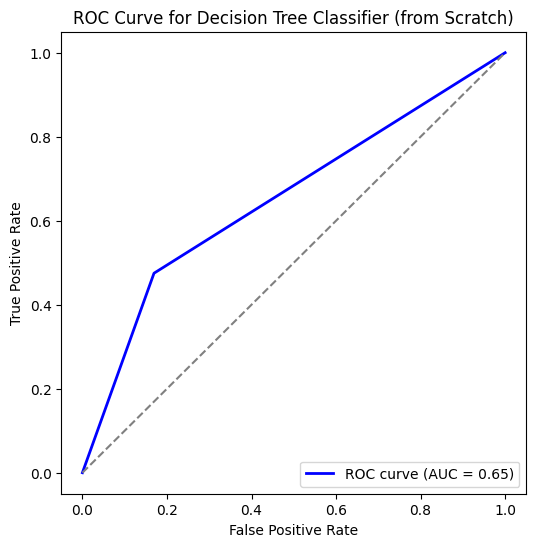

In [353]:
# ROC & AUC
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# Get probabilities (or scores)
y_pred_proba = tree.predict_proba(X_test)

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier (from Scratch)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# # ROC & AUC

# # predict probabilities
# tree_probs = tree.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# tree_probs = tree_probs[:, 1]
# # calculate scores
# ns_auc = roc_auc_score(y_test, tree_probs)
# lr_auc = roc_auc_score(y_test, tree_probs)
# # summarize scores
# print('Logistic: ROC AUC=%.3f' % (lr_auc))

# # calculate roc curves
# lr_fpr, lr_tpr, _ = roc_curve(y_test, tree_probs)
# # plot the roc curve for the model
# plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()

## Compare to scikit-learn

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(max_depth=3)
tree_sk.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
y_t_pred = tree_sk.predict(X_test)
accuracy_score(y_test, y_t_pred)

0.6956521739130435

In [ ]:
params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
}

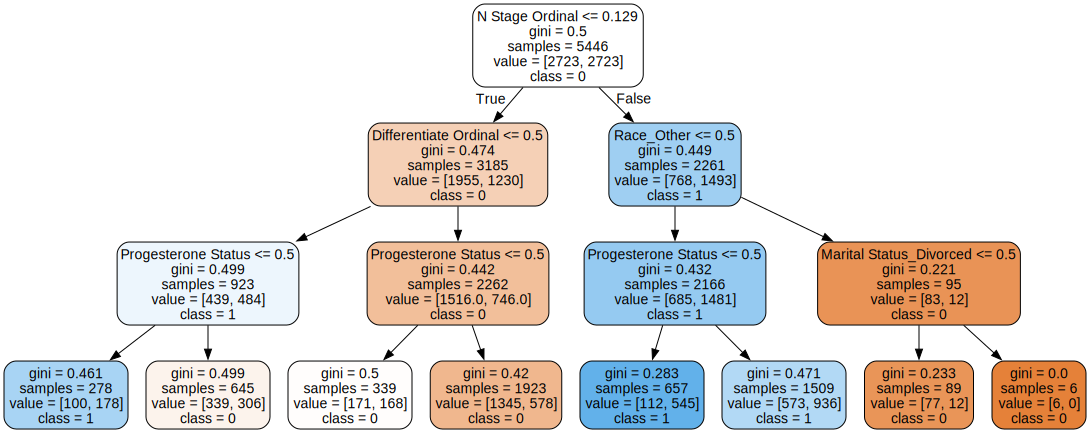

In [ ]:
from sklearn.tree import export_graphviz
from graphviz import Source

import os
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree_images")
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
    tree_sk, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "breast_cancer.dot"),
    feature_names = X.columns.tolist(),
    class_names = y.unique().astype(str).tolist(),
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "breast_cancer.dot"))